In [ ]:
#Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [ ]:
#Dataframe
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset_path = '/content/drive/My Drive/Datasets/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
senti_map = {0:"NEGATIVE", 2:"NEUTRAL", 4:"POSITIVE"}
def decode_sentiment(label):
    return senti_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x:decode_sentiment(x))

Text(0.5, 1.0, 'Dataset Labels')

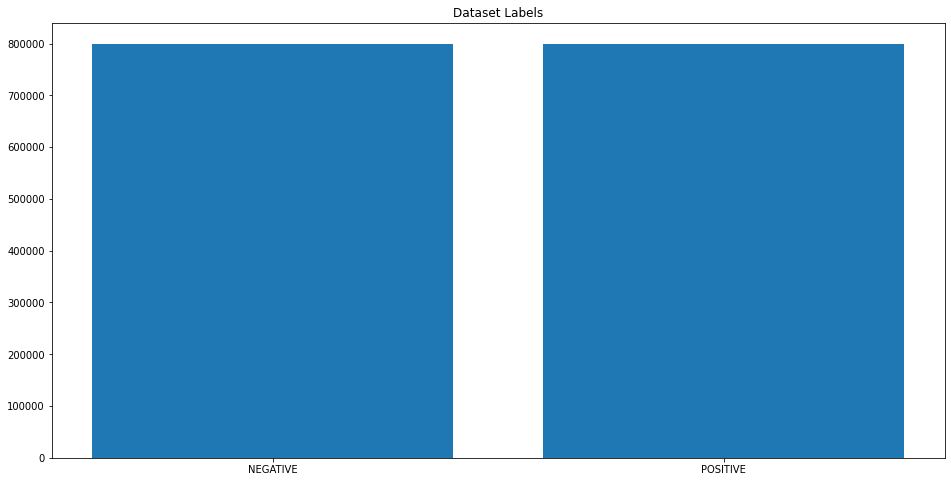

In [ ]:
from collections import Counter
target_count = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(),target_count.values())
plt.title("Dataset Labels")

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def pre_process(text, stem = False):
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip() #Cleaning the text
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else: tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: pre_process(x))

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape,df_test.shape

((1280000, 6), (320000, 6))

WORD2VEC

In [ ]:
%%time
documents = [text_.split() for text_ in df_train.text]
documents[0]

CPU times: user 2.39 s, sys: 290 ms, total: 2.68 s
Wall time: 2.68 s


In [ ]:
import gensim

w2v_model = gensim.models.word2vec.Word2Vec(size=300,window=7,min_count=10,workers=8)

In [ ]:
%%time
w2v_model.build_vocab(documents)

CPU times: user 7.85 s, sys: 50.6 ms, total: 7.9 s
Wall time: 7.91 s


In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab Size", vocab_size)
words

Vocab Size 30369


dict_keys(['ya', 'quot', 'like', 'palm', 'pre', 'charger', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch', 'felt', 'earthquake', 'afternoon', 'seems', 'shirts', 'likey', 'pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'didnt', 'say', 'could', 'go', 'work', 'today', 'yeah', 'clear', 'view', 'one', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'added', 'next', 'tm', 'video', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys', 'gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action', 'happy', 'mothers', 'grown', 'n', 'amp', 'lil', 'prego', 'lol', 'playing', 'everyone', 'loved', 'bless', 'back', 'eating', 'dinner', 'chat', 'room', 'many', 'heck', 'way', 'heights', 'want', 'trade', 'tired', 'saying', 'goodbye', 'chicago', 'stole', 'half', '12', 'mai', 'tai', 'inbound', 'suddenly', 'trouble', 'rel

In [ ]:
%%time
w2v_model.train(documents,total_examples=len(documents), epochs=32)

CPU times: user 19min 43s, sys: 3.43 s, total: 19min 47s
Wall time: 10min 4s


(263121488, 295270528)

In [ ]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5759694576263428),
 ('loves', 0.5587611198425293),
 ('loved', 0.5465474724769592),
 ('adore', 0.5308386087417603),
 ('amazing', 0.5141891837120056),
 ('looove', 0.4743312895298004),
 ('awesome', 0.4654847979545593),
 ('loveee', 0.46147072315216064),
 ('loooove', 0.45007944107055664),
 ('loove', 0.4392862617969513)]

RNN

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, LSTM, GRU, Embedding, Flatten,Conv1D, MaxPool1D
from keras import  utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print('Total Words', vocab_size)

Total Words 290419
CPU times: user 14.1 s, sys: 115 ms, total: 14.2 s
Wall time: 14.2 s


In [ ]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

CPU times: user 21 s, sys: 503 ms, total: 21.5 s
Wall time: 21.6 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_train.shape, y_test.shape

((1280000, 1), (320000, 1))

Embedding Layer

In [ ]:
for word, i in tokenizer.word_index.items():
  print('WWWWW:',word)
  print('III:',i)
  print(w2v_model.wv[word])
  print('________________')
  if i==5: break

WWWWW: good
III: 1
[ 1.47611725e+00  8.04436505e-02  1.37357056e+00  3.62100959e-01
  3.76430541e-01 -1.35073769e+00  9.88926291e-02  3.10018241e-01
  6.37814462e-01 -2.32547355e+00  1.00914395e+00  2.68663824e-01
  3.21301550e-01 -1.46175647e+00 -6.70697689e-01 -1.10247505e+00
  1.19703501e-01  3.11254412e-01 -6.78307235e-01  6.99777246e-01
  2.12173723e-02  7.69646525e-01  1.06492281e+00 -8.09410751e-01
  7.35575378e-01  6.18717670e-01  8.91793132e-01 -4.77664292e-01
 -1.25717536e-01 -5.72567999e-01 -1.08226299e+00 -1.51735532e+00
 -3.27149183e-01  1.71781731e+00 -7.79205203e-01 -1.28055322e+00
  5.65553367e-01  5.34021378e-01  3.12969238e-01 -8.40864778e-01
  5.54359257e-01  1.40234017e+00 -6.85388505e-01  3.46145660e-01
 -5.59499800e-01  7.93140650e-01  5.28991520e-01 -2.67066687e-01
 -6.06405959e-02  1.19117939e+00  7.69316673e-01 -1.10816312e+00
 -9.30391848e-01  1.12203352e-01  2.56623346e-02 -2.52508670e-01
 -1.74282753e+00  5.54028511e-01 -1.42625362e-01  6.09002531e-01
  3.45

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_matrix.shape, embedding_matrix[:10]

((290419, 300),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.47611725,  0.08044365,  1.37357056, ...,  0.07616949,
         -0.11439368,  0.37106192],
        [ 0.97431374, -1.07130039,  0.00981011, ...,  0.31232104,
         -0.83694649, -1.00620294],
        ...,
        [-0.31084457,  0.1639224 , -0.36841458, ...,  0.87133288,
         -1.02989233,  0.19336893],
        [-0.358004  ,  0.20479573, -0.54240912, ...,  2.38962555,
         -1.12106764, -0.13845707],
        [ 1.12609398,  0.10825972, -1.07222795, ...,  0.30977038,
          0.39878362, -1.17641628]]))

In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix],input_length=300, trainable=False)

In [ ]:
#Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='Val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='Val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(X_train, y_train, batch_size=1024,epochs=10,validation_split=0.1,verbose=1, callbacks=callbacks)

Epoch 1/10
1125/1125 [==============================] - 606s 539ms/step - loss: 0.5034 - accuracy: 0.7507 - val_loss: 0.4671 - val_accuracy: 0.7793
Epoch 2/10
1125/1125 [==============================] - 613s 545ms/step - loss: 0.4782 - accuracy: 0.7679 - val_loss: 0.4567 - val_accuracy: 0.7840
Epoch 3/10
1125/1125 [==============================] - 608s 540ms/step - loss: 0.4712 - accuracy: 0.7725 - val_loss: 0.4534 - val_accuracy: 0.7870
Epoch 4/10
1125/1125 [==============================] - 612s 544ms/step - loss: 0.4674 - accuracy: 0.7748 - val_loss: 0.4497 - val_accuracy: 0.7887
Epoch 5/10
1125/1125 [==============================] - 612s 544ms/step - loss: 0.4651 - accuracy: 0.7766 - val_loss: 0.4480 - val_accuracy: 0.7894
Epoch 6/10
1125/1125 [==============================] - 615s 546ms/step - loss: 0.4629 - accuracy: 0.7775 - val_loss: 0.4482 - val_accuracy: 0.7897
Epoch 7/10
1125/1125 [==============================] - 609s 542ms/step - loss: 0.4618 - accuracy: 0.7781 - val_

In [ ]:
%%time
score = model.evaluate(X_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 54s 173ms/step - loss: 0.4427 - accuracy: 0.7921

ACCURACY: 0.7920874953269958
LOSS: 0.4426688551902771
CPU times: user 49.7 s, sys: 2.74 s, total: 52.4 s
Wall time: 54.6 s


In [ ]:
def predict(text):
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
  pred = model.predict([x_test])[0]
  return pred

In [ ]:
predict("I love movies")

array([0.9612461], dtype=float32)

In [ ]:
predict("I hate drama")

array([0.02332387], dtype=float32)

In [ ]:
predict("COVID is bad")

array([0.21364346], dtype=float32)

In [ ]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
import pickle
model.save('RNNModel.h5')
w2v_model.save('W2VModel.w2v')
pickle.dump(tokenizer, open('tokenizer.pkl', "wb"), protocol = 0)
pickle.dump(encoder, open('encoder.pkl', "wb"), protocol=0)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
